# Code reference: https://github.com/joewandy/hlda(open source)
# hLDA reference: http://cocosci.princeton.edu/tom/papers/ncrp.pdf
## hlda_sampler.py is the Gibbs sampler for hLDA inference, based on the implementation from Mallet having a fixed depth on the nCRP tree.

In [1]:
### An environment configuration
# python: 3.7.3
# numpy: 1.16.4
# pandas: 0.24.2
# csv: 1.0
# pattern: 3.6
# pyLDAvis: 2.1.2
# matplotlib: 3.1.0
# re: 2.2.1
# gensim: 3.8.1
# wordcloud: 1.6.0
# ipywidgets: 7.5.0
# IPython: 7.6.1

In [2]:
import numpy as np
import pandas as pd
import csv
import pattern
import pyLDAvis.gensim as gensimvis
import matplotlib.pyplot as plt
import itertools
import hlda_sampler
import re
from gensim.utils import lemmatize
from gensim.corpora import Dictionary
from gensim.corpora import MmCorpus
from gensim.models.ldamodel import LdaModel
from gensim.models import hdpmodel
from gensim.parsing.preprocessing import STOPWORDS
from wordcloud import WordCloud
from ipywidgets import widgets
from IPython.core.display import HTML, display

/Users/wangyaoting/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/Users/wangyaoting/anaconda3/lib/python3.7/site-packages/Pattern-3.6-py3.7.egg/pattern/text/en/../../../../nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/Users/wangyaoting/anaconda3/lib/python3.7/site-packages/Pattern-3.6-py3.7.egg/pattern/text/en/../../../../nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict
/Users/wangyaoting/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: D

In [3]:
df = pd.read_csv("NASA_DataSets_Scrub.tsv",sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24356 entries, 0 to 24355
Data columns (total 5 columns):
title          24356 non-null object
issued         24356 non-null object
modified       24356 non-null object
description    24289 non-null object
id             24356 non-null object
dtypes: object(5)
memory usage: 951.5+ KB


In [4]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24289 entries, 0 to 24355
Data columns (total 5 columns):
title          24289 non-null object
issued         24289 non-null object
modified       24289 non-null object
description    24289 non-null object
id             24289 non-null object
dtypes: object(5)
memory usage: 1.1+ MB


# Lemmatize, Stopword removal

In [5]:
def decode(s):
    return s.decode('utf-8').split('/')[0]
def stop_word_lem(doc):
    return lemmatize(doc, stopwords=STOPWORDS)
    
def lemm(corpus):
    cor_lem = []
    doc_lem = list(map(stop_word_lem,corpus))
    for i,doc in enumerate(doc_lem):
        cor_lem.append(list(map(decode,doc)))
        if i % 2000 == 0:
            print(i)
    return cor_lem

In [7]:
print('-Start Lemmatize-')
cor_lemm = lemm(df.description[:])
print('-End Lemmatize-')

-Start Lemmatize-
0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
-End Lemmatize-


In [8]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(cor_lemm, min_count=20)
cor_lemm_add_bi = cor_lemm.copy()
for idx in range(len(cor_lemm_add_bi)):
    for token in bigram[cor_lemm_add_bi[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            cor_lemm_add_bi[idx].append(token)



# Build Dictionary

In [9]:
len(cor_lemm_add_bi)

24289

In [10]:
common_dictionary = Dictionary(cor_lemm_add_bi)

In [11]:
common_corpus = [common_dictionary.doc2bow(text) for text in cor_lemm_add_bi]

In [12]:
print('Number of unique tokens: %d' % len(common_dictionary))
print('Number of documents: %d' % len(common_corpus))

Number of unique tokens: 39845
Number of documents: 24289


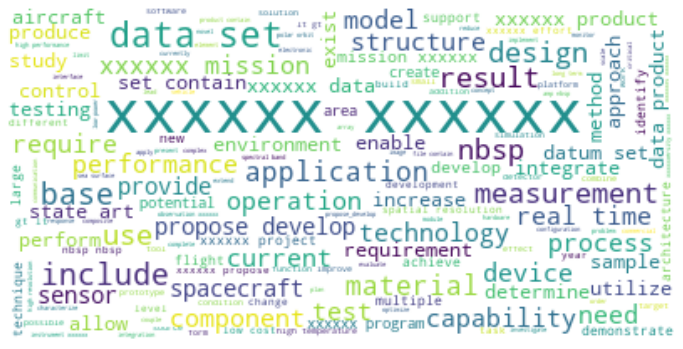

In [13]:
# word cloud visualiztion to glance the corpus outlook
word_collection = itertools.chain.from_iterable(cor_lemm_add_bi)
wordcloud = WordCloud(background_color='white').generate(' '.join(word_collection))
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# LDA

In [58]:
# Train LDA model.
# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = common_dictionary[0]
id2word = common_dictionary.id2token

model = LdaModel(
    corpus=common_corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [193]:
def show_doc_LDA(d=0):
    
    def takeSecond(elem):
        return elem[1]
    
    top_dis = model.get_document_topics(common_corpus[d])
    top_dis.sort(key = takeSecond, reverse = True)
    
    for top, prob in top_dis: 
        msg = 'Topic %d (weight %.2f): ' % (top, prob)
        if prob > 0.5:
            colour = 'blue'
        elif 0.2 < prob < 0.5:
            colour = 'red'
        else:
            colour = 'green'
        msg += re.sub('.....\*','',model.print_topic(top))
        output = '<h3><span style="color:%s">%s</span></h3>' % (colour , msg)
        display(HTML(output))
        
    display(HTML('<hr/><h5>Processed Document</h5>'))

    doc = cor_lemm_add_bi[d]
    output = ''
    for n in range(len(doc)):
        w = doc[n]
        output += '<span style="color:black">%s</span> ' % (w)
    display(HTML(output))

<>:17: DeprecationWarning: invalid escape sequence \*
<>:17: DeprecationWarning: invalid escape sequence \*
<>:17: DeprecationWarning: invalid escape sequence \*
<ipython-input-193-e9bbb2a27eaa>:17: DeprecationWarning: invalid escape sequence \*
  msg += re.sub('.....\*','',model.print_topic(top))


In [194]:
widgets.interact(show_doc_LDA, d=(2020, len(cor_lemm_add_bi)-1))

interactive(children=(IntSlider(value=2020, description='d', max=24288, min=2020), Output()), _dom_classes=('w…

<function __main__.show_doc_LDA(d=0)>

In [59]:
vis_data = gensimvis.prepare(model, common_corpus, common_dictionary)
pyLDAvis.display(vis_data)

/Users/wangyaoting/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


# hLDA

# https://github.com/joewandy/hlda/blob/master/hlda/sampler.py

In [7]:
common_dictionary_t = Dictionary(cor_lemm_add_bi)
voc = sorted(list(common_dictionary_t.values()))
voc_ind = {k:v for v,k in enumerate(voc)}
new_corpus = []
for doc in cor_lemm_add_bi:
    new_doc = []
    for word in doc:
        word_idx = voc_ind[word]
        new_doc.append(word_idx)
    new_corpus.append(new_doc)


In [8]:
n_samples = 50        # no of iterations for the sampler
alpha = 10.0          # smoothing over level distributions
gamma = 1.0           # CRP smoothing parameter; number of imaginary customers at next, as yet unused table
eta = 0.1             # smoothing over topic-word distributions
num_levels = 3        # the number of levels in the tree
display_topics = 25   # the number of iterations between printing a brief summary of the topics so far
n_words = 5           # the number of most probable words to print for each topic after model estimation
with_weights = False  # whether to print the words with the weights

In [9]:
hlda = hlda_sampler.HierarchicalLDA(new_corpus, voc, alpha=alpha, gamma=gamma, eta=eta, num_levels=num_levels)
hlda.estimate(n_samples, display_topics=display_topics, n_words=n_words, with_weights=with_weights)

HierarchicalLDA sampling

......................... 25
topic=0 level=0 (documents=24289): xxxxxx, provide, time, measurement, base, 
    topic=1 level=1 (documents=1722): xxxxxx, develop, technology, design, mission, 
        topic=2 level=2 (documents=1299): xxxxxx, water, nbsp, space, process, 
        topic=24 level=2 (documents=103): spice, navcam, mi, hazcam, rss, 
        topic=47 level=2 (documents=94): hrd, dust, rss, spice, cda, 
        topic=76 level=2 (documents=70): salinity, cruise, ocean, spur, region, 
        topic=94 level=2 (documents=27): corrosion, coating, nbsp, exposure, alloy, 
        topic=97 level=2 (documents=6): stable, alpha, autoregressive, particle_filter, invariant, 
        topic=108 level=2 (documents=5): batteryless, xxxxxxheld, distribute, implantable, drag_reduction, 
        topic=128 level=2 (documents=4): ts, tp, latest, emissivity, te, 
        topic=135 level=2 (documents=9): fpa, micron, superlattice, fpas, mbe, 
        topic=167 level=2 (do

        topic=9 level=2 (documents=2193): xxxxxx, product, datum, data, file, 
        topic=10 level=2 (documents=494): xxxxxx, data, surface, track, instrument, 
        topic=12 level=2 (documents=1340): high, temperature, thruster, heat, energy, 
        topic=14 level=2 (documents=2956): laser, high, nbsp, power, detector, 
        topic=17 level=2 (documents=233): observation, analysis, xxxxxx, error, background, 
        topic=32 level=2 (documents=491): asteroid, contain, data, set, data_set, 
        topic=52 level=2 (documents=6): aac, techedsat, orbcomm, cubesat, xxxxxxtec, 
        topic=56 level=2 (documents=15): bci, nrai, xxxxxxspoofing, dfms, rosina, 
        topic=58 level=2 (documents=59): grs, spice, themis, spice_themis, radio, 
        topic=98 level=2 (documents=37): lcross, nm, k_nsm, uncalibrated, spectra, 
        topic=101 level=2 (documents=18): ionosphere, file, thermosphere, etwa, doq, 
        topic=127 level=2 (documents=11): radar, rzsm, soil_moisture, m

        topic=476 level=2 (documents=5): regenerator, locd, abcd, minute_interval, ahearnetal, 
        topic=483 level=2 (documents=5): camls, bull, omni, public_data, mls, 
        topic=493 level=2 (documents=6): ls, rationing, ﬂew, galler, galvanic, 
        topic=498 level=2 (documents=7): cunningham, fy, xxxxxxlaminate, ascent, disciplinary, 
        topic=524 level=2 (documents=9): factory, xxxxxxxer, unmodified, tiny, kdd, 
        topic=525 level=2 (documents=4): microheater, comet, fascinating, unused, planetesimal, 
        topic=527 level=2 (documents=6): spatial, api, ﬂew, galler, galvanic, 
        topic=539 level=2 (documents=5): wand, fractal, mirror, ifcs, xxxxxxns, 
        topic=551 level=2 (documents=2): ppb, ndir, negligible, eddy_covariance, original, 
        topic=568 level=2 (documents=4): edi, cearex, letter, multus_platform, north, 
        topic=570 level=2 (documents=2): npoess, ipo, nast, excitation, infrared_microwave, 
        topic=574 level=2 (document

        topic=392 level=2 (documents=6): ﬂew, galley, galvanometric, galvanically, galvanic, 
        topic=394 level=2 (documents=9): fireball, bolide, radiate, kt, prlc, 
        topic=401 level=2 (documents=6): hasi, tactical, symmetrical, entry_descent, tracker, 
        topic=425 level=2 (documents=3): lighweight, axisymmetric, ﬂew, galley, galvanically, 
        topic=431 level=2 (documents=5): solar_array, mma, fdm, hawk, kw, 
        topic=451 level=2 (documents=4): mapper, breath, ﬂew, galvanic, galprop, 
        topic=462 level=2 (documents=7): aidjex, camp, refrigerator, sea, downloadable, 
        topic=465 level=2 (documents=9): athos, xxxxxxpress, induced_fluorescence, lif, display, 
        topic=484 level=2 (documents=1): ﬂew, galley, galvanometric, galvanically, galvanic, 
        topic=521 level=2 (documents=1): ﬂew, galley, galvanometric, galvanically, galvanic, 
        topic=529 level=2 (documents=2): ﬂew, galley, galvanometric, galvanically, galvanic, 
        top

        topic=4 level=2 (documents=1373): design, develop, control, technology, space, 
        topic=18 level=2 (documents=2657): data, set, data_set, datum, contain, 
        topic=26 level=2 (documents=29): xxxxxxar_conjunction, xxxxxxar, conjunction, cover, emg, 
        topic=30 level=2 (documents=134): academy, xxxxxxership, academy_program, project_xxxxxxing, xxxxxxing, 
        topic=34 level=2 (documents=48): ihw, february, ihw_conduct, trial, largely, 
        topic=48 level=2 (documents=3): aisrp, ﬂew, galley, galvanometric, galvanically, 
        topic=64 level=2 (documents=18): ntp, control, drum, reactor, nuclear, 
        topic=66 level=2 (documents=52): control, propulsion, sail, design, technology, 
        topic=72 level=2 (documents=31): rac, robotic, arm, robotic_arm, camera_rac, 
        topic=82 level=2 (documents=3): zonal, meniscus, src, internet, ﬂew, 
        topic=89 level=2 (documents=10): om, tega, ssi, meca, meet, 
        topic=110 level=2 (documents=10):

        topic=67 level=2 (documents=4): pioneer, bbn, selene, manet, eva, 
        topic=77 level=2 (documents=10): sparse, matrix, intf, step, delta, 
        topic=80 level=2 (documents=43): engine, fuel, valve, seal, test, 
        topic=151 level=2 (documents=7): techedsat, aac, disregard, erbe_s, xxxxxxtec, 
        topic=258 level=2 (documents=23): coma, cometary, comet, ion, pyramid, 
        topic=259 level=2 (documents=10): auroral, aurora, akr, sunlit, dayside, 
        topic=587 level=2 (documents=11): tbd, toughness, multus_platform, paragraph, norwegiansea, 
        topic=594 level=2 (documents=5): wlpi, epi, wafer, rectifier, ideality, 
        topic=621 level=2 (documents=9): sapflow, session, google, mashup, throttleable, 
        topic=694 level=2 (documents=2): sizing, condensational, tippable, enlargement, xxxxxxde, 
        topic=718 level=2 (documents=6): collaboration, mobility, energy_harvesting, thermo, piezo, 
        topic=801 level=2 (documents=5): xxxxxxning

        topic=938 level=2 (documents=6): atlantic_stratocumulus, bleed, noy, nox, liquefaction, 
        topic=994 level=2 (documents=1): everest, helicopter, ﬂew, gallery, galvanic, 
        topic=1026 level=2 (documents=6): epa_ss_st_louis, regenerative, ﬂew, gam, galvanometric, 
        topic=1040 level=2 (documents=6): circuit, embed, function, osa, breaker, 
        topic=1048 level=2 (documents=2): thermal_control, antistatic, ﬂew, galler, galvanic, 
        topic=1065 level=2 (documents=9): crystal, tfr, adiz, mineralogical, montoring, 
        topic=1075 level=2 (documents=7): technology, atlas, lgrs, steered, radiation_shielding, 
        topic=1101 level=2 (documents=4): mem, xxxxxxcooler, ﬂew, galvanostatic, galvanically, 
        topic=1131 level=2 (documents=3): xps, meaurement, rf, galley, galvanically, 
    topic=49 level=1 (documents=121): applicable, xxxxxx, rm, mem, technology, 
        topic=50 level=2 (documents=9): damper, rotary, joint, exercise, motion, 
        

        topic=924 level=2 (documents=3): daac, topex_poseidon, primary_responsibility, eosdis, responsibility, 
        topic=955 level=2 (documents=7): geoid, undulation, dr, mr, committee, 
        topic=961 level=2 (documents=4): ﬂew, galley, galvanometric, galvanically, galvanic, 
        topic=975 level=2 (documents=3): ers, amplitude, gallium, galvanometric, galvanically, 
        topic=978 level=2 (documents=5): polynomial, propylene, lox, gmdh, equation, 
        topic=986 level=2 (documents=8): retirement, defective, airframe, satellite, regenerator, 
        topic=999 level=2 (documents=3): indigenous, yakutia, siberium, community, subsistence, 
        topic=1089 level=2 (documents=5): molecule, transdermal, galley, galvanometric, galvanically, 
        topic=1093 level=2 (documents=8): elder, ik, yup, staff, eager, 
        topic=1132 level=2 (documents=7): meteo, planet, home, eumetcast, compliant, 
        topic=1156 level=2 (documents=4): microphone, acoustic, commercial

In [168]:
colour_map = {
    0: 'blue',
    1: 'red',
    2: 'green'
}

def show_doc_hLDA(d=0):
    
    node = hlda.document_leaves[d]
    path = []
    while node is not None:
        path.append(node)
        node = node.parent
    path.reverse()   
    
    n_words = 10
    with_weights = False    
    for n in range(len(path)):
        node = path[n]
        colour = colour_map[n] 
        msg = 'Level %d Topic %d: ' % (node.level, node.node_id)
        msg += node.get_top_words(n_words, with_weights)
        output = '<h%d><span style="color:%s">%s</span></h3>' % (n+1, colour, msg)
        display(HTML(output))
        
    display(HTML('<hr/><h5>Processed Document</h5>'))

    doc = cor_lemm_add_bi[d]
    output = ''
    for n in range(len(doc)):
        w = doc[n]
        l = hlda.levels[d][n]
        colour = colour_map[l]
        output += '<span style="color:%s">%s</span> ' % (colour, w)
    display(HTML(output))

In [195]:
widgets.interact(show_doc_hLDA, d=(2020, len(cor_lemm_add_bi)-1))

interactive(children=(IntSlider(value=2020, description='d', max=24288, min=2020), Output()), _dom_classes=('w…

<function __main__.show_doc_hLDA(d=0)>

# To Deliverable Table

In [13]:
def topic(row):
    node = hlda.document_leaves[row.name]
    path = []
    while node is not None:
        path.append(node)
        node = node.parent
    node = path[-1]
    with_weights = False
    n_words = 10
    return node.node_id
def sub_topic_1(row):
    node = hlda.document_leaves[row.name]
    path = []
    while node is not None:
        path.append(node)
        node = node.parent
    node = path[-2]
    with_weights = False
    n_words = 10
    return node.node_id
def sub_topic_2(row):
    node = hlda.document_leaves[row.name]
    path = []
    while node is not None:
        path.append(node)
        node = node.parent
    node = path[-3]
    with_weights = False
    n_words = 10
    return node.node_id

In [52]:
df = pd.read_csv("NASA_DataSets_Scrub.tsv",sep='\t')
df.info()
df = df.dropna()
df = df.reset_index()
df['topic'] = df.apply(topic, axis = 1)
df['subtopic_1'] = df.apply(sub_topic_1, axis = 1)
df['subtopic_2'] = df.apply(sub_topic_2, axis = 1)
df_o = pd.read_csv("NASA_DataSets_Scrub.tsv",sep='\t')
deliverable1 = df_o.merge(df, how = 'left', on = ['id','title','issued','modified','description'])
deliverable1 = deliverable1.fillna('')
deliverable1_ = deliverable1[['topic','subtopic_1','subtopic_2','id']]
deliverable1_.to_csv('topic_doc.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24356 entries, 0 to 24355
Data columns (total 5 columns):
title          24356 non-null object
issued         24356 non-null object
modified       24356 non-null object
description    24289 non-null object
id             24356 non-null object
dtypes: object(5)
memory usage: 951.5+ KB


In [53]:
t = pd.DataFrame(data = voc, columns=['feature'])
t['topics'] = np.empty((len(t), 0)).tolist()
t['topic_weight'] = np.empty((len(t), 0)).tolist()
t = t.set_index('feature')
duplicate = []
for doc_num in range(len(cor_lemm_add_bi)):
    node = hlda.document_leaves[doc_num].parent.parent
    tp = node.node_id
    if tp in duplicate:
        continue
    else:
        duplicate.append(tp)
    k = node.get_topic_word(True).keys()
    we = node.get_topic_word(True).values()
    for a,b in zip(list(k), list(we)):
        t.loc[a, 'topics'].append(tp)
        t.loc[a, 'topic_weight'].append(b)

t['sub_topics_1'] = np.empty((len(t), 0)).tolist()
t['sub_topic_1_weight'] = np.empty((len(t), 0)).tolist()
duplicate = []
for doc_num in range(len(cor_lemm_add_bi)):
    node = hlda.document_leaves[doc_num].parent
    tp = node.node_id
    if tp in duplicate:
        continue
    else:
        duplicate.append(tp)
    k = node.get_topic_word(True).keys()
    we = node.get_topic_word(True).values()
    for a,b in zip(list(k), list(we)):
        t.loc[a, 'sub_topics_1'].append(tp)
        t.loc[a, 'sub_topic_1_weight'].append(b)

t['sub_topics_2'] = np.empty((len(t), 0)).tolist()
t['sub_topic_2_weight'] = np.empty((len(t), 0)).tolist()
duplicate = []
for doc_num in range(len(cor_lemm_add_bi)):
    node = hlda.document_leaves[doc_num]
    tp = node.node_id
    if tp in duplicate:
        continue
    else:
        duplicate.append(tp)
    k = node.get_topic_word(True).keys()
    we = node.get_topic_word(True).values()
    for a,b in zip(list(k), list(we)):
        t.loc[a, 'sub_topics_2'].append(tp)
        t.loc[a, 'sub_topic_2_weight'].append(b)
t.reset_index(level=0, inplace=True)
t.to_csv('word_topic.csv')